# How to Win a Data Science Competition: Final Project Part 2 of 2

## Import Packages

In [1]:
import pandas as pd
import gc
import pickle
import time
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
import lightgbm as lgb

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

time_start = time.time()

## Load Data

In [12]:
data_monthly = pd.read_pickle('data_monthly.pkl')

# remove months from data that do not have previous (lagged) data. 
# since the lags were up to 12 months, rmove date_block_num 0-11
data_monthly = data_monthly[data_monthly.date_block_num > 11]

test = pd.read_csv("test.csv").set_index('ID')            

## 10) Prepare Train, Validation, Development, and Test Sets

In [3]:
X_train = data_monthly[data_monthly.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data_monthly[data_monthly.date_block_num < 33]['item_cnt_month']

X_val   = data_monthly[data_monthly.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val   = data_monthly[data_monthly.date_block_num == 33]['item_cnt_month']

X_test  = data_monthly[data_monthly.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_dev   = data_monthly[data_monthly.date_block_num == 32].drop(['item_cnt_month'], axis=1)
y_dev   = data_monthly[data_monthly.date_block_num == 32]['item_cnt_month']

## 11) Tune Hyperparameters with Dev Set

In [4]:
# Parameter Tuning 
# this code helped determine the right min_child_weight,
'''
params = {
         'max_depth': [8],
         'min_child_weight': [300],
         'subsample': [0.8],
         'colsample_by_tree': [0.8],
         }

xgb1 = XGBRegressor(objective='reg:squarederror',
                    nthread=-1, 
                    seed=27,
                    verbose=True
                   )

xgb_grid = GridSearchCV(xgb1,
                        params,
                        eval_metric="rmse", 
                        cv = 5, 
                        n_jobs = -1
                       )

xgb_grid.fit(X_dev, y_dev)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
'''

'\nparams = {\n         \'max_depth\': [8],\n         \'min_child_weight\': [300],\n         \'subsample\': [0.8],\n         \'colsample_by_tree\': [0.8],\n         }\n\nxgb1 = XGBRegressor(objective=\'reg:squarederror\',\n                    nthread=-1, \n                    seed=27,\n                    verbose=True\n                   )\n\nxgb_grid = GridSearchCV(xgb1,\n                        params,\n                        eval_metric="rmse", \n                        cv = 5, \n                        n_jobs = -1\n                       )\n\nxgb_grid.fit(X_dev, y_dev)\n\nprint(xgb_grid.best_score_)\nprint(xgb_grid.best_params_)\n'

## 12) Build Model and Evaluate with Train and Val Sets
#### Comments about the model
> Used brute force to optimize hyperparameters:<br> 
>> *n_estimators* is arbritrary since we are using early stopping<br>
>> *max_depth* is very important. 9 leads to bad overfitting. 8 is best<br>
>> *min_child_weight* is also important. 300 is best<br> 
>> This model results in a score of 0.939 which is good enough for 10/10<br>

In [5]:
model_xgb = XGBRegressor(
        n_estimators=1000,
        max_depth=8,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8,
        gamma=0,
        objective='reg:squarederror',
        nthread=-1, 
        seed=27)
   
model_xgb.fit(
        X_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        verbose=True, 
        early_stopping_rounds = 10)

C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:47:26] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.14999	validation_1-rmse:1.11648
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10387	validation_1-rmse:1.0788
[2]	validation_0-rmse:1.06075	validation_1-rmse:1.0474
[3]	validation_0-rmse:1.0294	validation_1-rmse:1.02239
[4]	validation_0-rmse:0.999444	validation_1-rmse:1.00146
[5]	validation_0-rmse:0.973948	validation_1-rmse:0.984007
[6]	validation_0-rmse:0.953362	validation_1-rmse:0.969739
[7]	validation_0-rmse:0.936457	validation_1-rmse:0.957977
[8]	validation_0-rmse:0.920865	validation_1-rmse:0.948704
[9]	validation_0-rmse:0.907646	validation_1-rmse:0.940508
[10]	validation_0-rmse:0.896293	validation_1-rmse:0.934217
[11]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbosity=1)

#### Examine Feature Importance

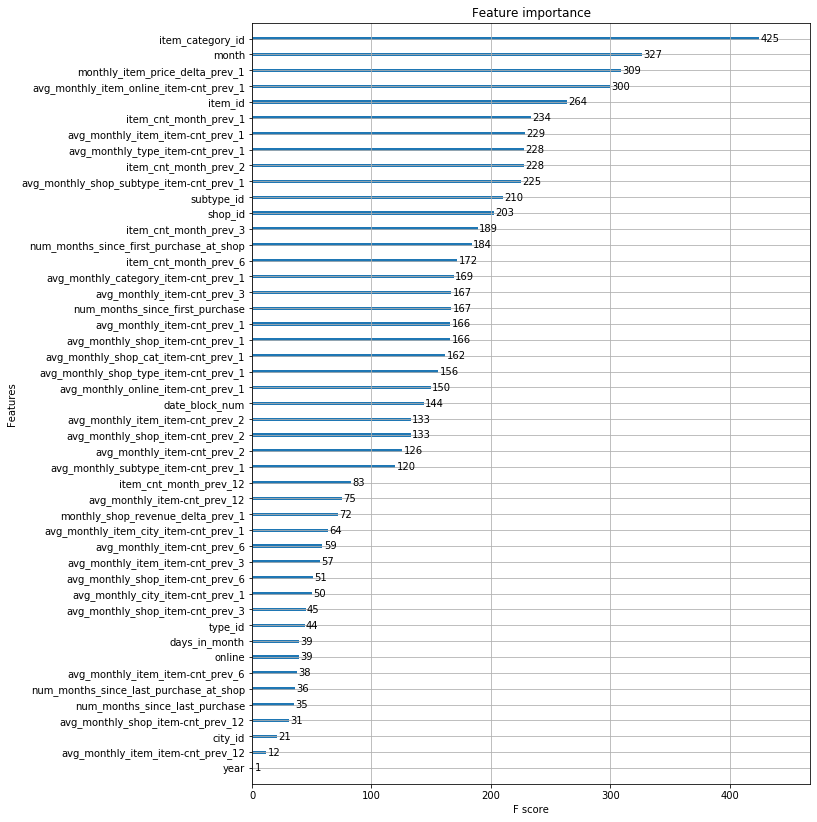

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=model_xgb, ax=ax)

## 13) Predict using Test Set and save
> At this point, the public score is 0.939 which gives a 10/10

In [7]:
pred_test = model_xgb.predict(X_test).clip(0, 20)
pred_val = model_xgb.predict(X_val).clip(0,20) # for ensembling
pred_dev = model_xgb.predict(X_dev).clip(0,20) # for ensembling

pickle.dump(model_xgb, open("model_xgb", "wb"))

In [8]:
submission_xgb = pd.DataFrame({"ID": test.index, "item_cnt_month": pred_test})
submission_xgb.to_csv('submission_xgb.csv', index=False)

print('Total time for XGBRegressor (seconds: '+str((time.time() - time_start)))

Total time for XGBREgressor (seconds: 514.204106092453


## 14) Esemble

#### First Level Model: XGBRegressor
> Use previous XGBRegressor as first level model 1 (pred_test)

#### First Level Model: LGB
> Use the model from the week 4 assignment<br>
> Takes approximately 140 seconds to run<br>
> Best score was 0.9471 for a score of 8/10<br>

In [22]:
time_start_lgb = time.time()
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }

model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb_test = model_lgb.predict(X_test).clip(0,20)

pickle.dump(model_lgb, open("model_lgb", "wb"))

In [23]:
submission_lgb = pd.DataFrame({"ID": test.index, "item_cnt_month": pred_lgb_test})
submission_lgb.to_csv('submission_lgb.csv', index=False)

print('Total time for lgb (seconds: '+str((time.time() - time_start_lgb)))

Total time for lgb (seconds: 149.59635376930237


#### First Level Model: Linear Regression

In [10]:
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Ensemble 1: Average XGBRegressor and LGB
> Score is 0.938 which is slightly better than just XGBRegressor for a score of 10/10<br>

In [11]:
esemble1 = pd.DataFrame({"ID": test.index, "item_cnt_month_xgb": pred_test, "item_cnt_month_lgb": pred_lgb_test})
esemble1['item_cnt_month'] = (esemble1['item_cnt_month_xgb'] + esemble1['item_cnt_month_lgb']) / 2
esemble1.drop(['item_cnt_month_xgb','item_cnt_month_lgb'], axis=1, inplace=True)
esemble1.to_csv('submission_esemble1.csv', index=False)

#### Esemble 2: Stacking of XBGRegressor, LGB, and LR for several months with a LR meta model
> Score is 0.9465 which is worse than ensemble 1 and just XGBRegressor for a scmore of 8/10<br>
> Likely the use of linear regression as a first stage model is throwing off the results<br>

In [12]:
# create new test sets. 

# X_val and y_val are for date_block_num == 33 as previously defined
# X_dev and y_dev are for date_block_num == 32 as previously defined

# just going to hardcode some new test sets

# date_block_num == 31
X_31   = data_monthly[data_monthly.date_block_num == 31].drop(['item_cnt_month'], axis=1)
y_31   = data_monthly[data_monthly.date_block_num == 31]['item_cnt_month']

# date_block_num == 30
X_30   = data_monthly[data_monthly.date_block_num == 30].drop(['item_cnt_month'], axis=1)
y_30   = data_monthly[data_monthly.date_block_num == 30]['item_cnt_month']

# date_block_num == 29
X_29   = data_monthly[data_monthly.date_block_num == 29].drop(['item_cnt_month'], axis=1)
y_29   = data_monthly[data_monthly.date_block_num == 29]['item_cnt_month']

# date_block_num == 28
X_28   = data_monthly[data_monthly.date_block_num == 28].drop(['item_cnt_month'], axis=1)
y_28   = data_monthly[data_monthly.date_block_num == 28]['item_cnt_month']

In [13]:
# pred_test is for date_block 34
# pred_val is for date_block 33
# pred_dev is for date_block 32

pred_31 = model_xgb.predict(X_31).clip(0,20) # pred_31 is for date_block 31
pred_30 = model_xgb.predict(X_30).clip(0,20) # pred_30 is for date_block 30
pred_29 = model_xgb.predict(X_29).clip(0,20) # pred_29 is for date_block 29
pred_28 = model_xgb.predict(X_28).clip(0,20) # pred_28 is for date_block 28

In [14]:
# predict linear regression for stacking
pred_lr_test = model_lr.predict(X_test.values) # date 34 prediction
pred_lr_val  = model_lr.predict(X_val.values)  # date 33 prediction
pred_lr_dev  = model_lr.predict(X_dev.values)  # date 32 prediction
pred_lr_31   = model_lr.predict(X_31.values)   # date 31 prediction
pred_lr_30   = model_lr.predict(X_30.values)   # date 30 prediction
pred_lr_29   = model_lr.predict(X_29.values)   # date 29 prediction
pred_lr_28   = model_lr.predict(X_28.values)   # date 28 prediction

In [15]:
# predict lgb on the datasets for stacking

pred_lgb_val  = model_lgb.predict(X_val).clip(0,20)
pred_lgb_dev  = model_lgb.predict(X_dev).clip(0,20)
pred_lgb_31   = model_lgb.predict(X_31).clip(0,20)
pred_lgb_30   = model_lgb.predict(X_30).clip(0,20)
pred_lgb_29   = model_lgb.predict(X_29).clip(0,20)
pred_lgb_28   = model_lgb.predict(X_28).clip(0,20)

In [16]:
# create a new test set based on the original test set X_test. 
# we need to add the date_block_num 34 predictions from XGBRegressor to X_test2 
X_test2 = X_test.copy()
X_test2['y_pred_xbg'] = pred_test     #date 34 prediction
X_test2['y_pred_lr']  = pred_lr_test  #date 34 prediction
X_test2['y_pred_lgb'] = pred_lgb_test #date 34 prediction

In [17]:
# create a new training set based on _val (i.e., date_block_num 33).
# add the predictions for date_block_num 33 from the previous XGBRegressor to it
X_train2_val = X_val.copy()
y_train2_val = y_val.copy() 

X_train2_dev = X_dev.copy()
y_train2_dev = y_dev.copy()

X_train2_31  = X_31.copy()
y_train2_31  = y_31.copy()

X_train2_30  = X_30.copy()
y_train2_30  = y_30.copy()

X_train2_29  = X_29.copy()
y_train2_29  = y_29.copy()

X_train2_28  = X_28.copy()
y_train2_28  = y_28.copy()

X_train2_val['y_pred_xbg'] = pred_val     #date 33 prediction
X_train2_val['y_pred_lr']  = pred_lr_val  #date 33 prediction
X_train2_val['y_pred_lgb'] = pred_lgb_val #date 33 prediction

X_train2_dev['y_pred_xbg'] = pred_dev     #date 32 prediction
X_train2_dev['y_pred_lr']  = pred_lr_dev  #date 32 prediction
X_train2_dev['y_pred_lgb'] = pred_lgb_dev #date 32 prediction

X_train2_31['y_pred_xbg']  = pred_31      #date 31 prediction
X_train2_31['y_pred_lr']   = pred_lr_31   #date 31 prediction
X_train2_31['y_pred_lgb']  = pred_lgb_31  #date 31 prediction

X_train2_30['y_pred_xbg']  = pred_30      #date 30 prediction
X_train2_30['y_pred_lr']   = pred_lr_30   #date 30 prediction
X_train2_30['y_pred_lgb']  = pred_lgb_30  #date 30 prediction

X_train2_29['y_pred_xbg']  = pred_29      #date 29 prediction
X_train2_29['y_pred_lr']   = pred_lr_29   #date 29 prediction
X_train2_29['y_pred_lgb']  = pred_lgb_29  #date 29 prediction

X_train2_28['y_pred_xbg']  = pred_28      #date 28 prediction
X_train2_28['y_pred_lr']   = pred_lr_28   #date 28 prediction
X_train2_28['y_pred_lgb']  = pred_lgb_28  #date 28 prediction

X_train2 = pd.concat([X_train2_28, X_train2_29, X_train2_30, X_train2_31, X_train2_dev, X_train2_val])
y_train2 = pd.concat([y_train2_28, y_train2_29, y_train2_30, y_train2_31, y_train2_dev, y_train2_val])

In [19]:
model2_lr = LinearRegression()
model2_lr.fit(X_train2.values, y_train2)
y_test2 = model2_lr.predict(X_test2.values).clip(0,20)

In [20]:
esemble2 = pd.DataFrame({"ID": test.index, "item_cnt_month": y_test2})
esemble2.to_csv('submission_esemble2.csv', index=False)

#### Esemble 3: Stacking of XBGRegressor and LGB for several months with a LR meta model
> This provided the same score as esemble 2 for some reason (0.9465)<br>
> Maybe in esemble 2 the contribution of the first lr model was completely ignored<br> 

In [23]:
X_train3 = X_train2.copy()
X_train3.drop('y_pred_lr', axis=1, inplace=True)

y_train3 = y_train2.copy()

X_test3 = X_test2.copy()
X_test3.drop('y_pred_lr', axis=1, inplace=True)

model3_lr = LinearRegression()
model3_lr.fit(X_train3.values, y_train3)
y_test3 = model3_lr.predict(X_test3.values).clip(0,20)

In [24]:
esemble3 = pd.DataFrame({"ID": test.index, "item_cnt_month": y_test3})
esemble3.to_csv('submission_esemble3.csv', index=False)

# STOP

In [26]:
gc.collect();